In [1]:
import pandas as pd
import numpy as num

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from itertools import cycle
#import graphviz
import matplotlib.pyplot as plt

In [2]:
#fetch file from s3 bucket
import boto3

# When running on SageMaker, need execution role
from sagemaker import get_execution_role
role = get_execution_role()

# Declare bucket name, remote file, and destination
my_bucket = 'smarthome-ids'
orig_file = 'IoT Intrusion Dataset 2020.csv'
dest_file = 'df'

# Connect to S3 bucket and download file
s3 = boto3.resource('s3')
s3.Bucket(my_bucket).download_file(orig_file, dest_file)

Text(0.5, 0, 'category')

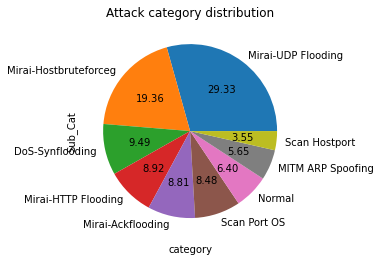

In [3]:

df = pd.read_csv(dest_file, delimiter=',')
#pd.options.display.float_format = '{:.0f}'.format

#df.columns = ["Src_IP", "Dst_IP", "Protocol", "Cat", "Idle_Mean","Flow_Pkts" "Sub_Cat", "Label"]

classes = pd.value_counts(df["Sub_Cat"], sort = True)
classes.plot(kind = 'pie', rot=0,autopct="%0.2f")
plt.title("Attack category distribution")

plt.xlabel("category")

In [4]:
print(classes)

Mirai-UDP Flooding       183554
Mirai-Hostbruteforceg    121181
DoS-Synflooding           59391
Mirai-HTTP Flooding       55818
Mirai-Ackflooding         55124
Scan Port OS              53073
Normal                    40073
MITM ARP Spoofing         35377
Scan Hostport             22192
Name: Sub_Cat, dtype: int64


In [4]:
cat=['Anomaly','Normal']
df['Label'].replace('Normal',0,inplace=True)
df['Label'].replace('Anomaly',1,inplace=True)
cat

['Anomaly', 'Normal']

In [5]:
#one-hot encoder for categorical values
df_enc=pd.get_dummies(df,columns=['Sub_Cat'])

In [6]:
#target variables
y=df_enc.iloc[:,[85,86,87,88,89,90,91,92,93]]

In [7]:
#feature names
class_labels=df['Sub_Cat'].unique()
class_labels

array(['Mirai-Ackflooding', 'DoS-Synflooding', 'Scan Port OS',
       'Mirai-Hostbruteforceg', 'Mirai-UDP Flooding',
       'Mirai-HTTP Flooding', 'Normal', 'Scan Hostport',
       'MITM ARP Spoofing'], dtype=object)

In [8]:
#check for null values
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

""


In [9]:
#check for infinity values
#ds = df.isin([num.inf, -num.inf]).values.sum()
#print(ds)
col_name=df.isin([num.inf, -num.inf]).any()
pd.set_option('display.max_rows',100)
col_name

Flow_ID              False
Src_IP               False
Src_Port             False
Dst_IP               False
Dst_Port             False
Protocol             False
Timestamp            False
Flow_Duration        False
Tot_Fwd_Pkts         False
Tot_Bwd_Pkts         False
TotLen_Fwd_Pkts      False
TotLen_Bwd_Pkts      False
Fwd_Pkt_Len_Max      False
Fwd_Pkt_Len_Min      False
Fwd_Pkt_Len_Mean     False
Fwd_Pkt_Len_Std      False
Bwd_Pkt_Len_Max      False
Bwd_Pkt_Len_Min      False
Bwd_Pkt_Len_Mean     False
Bwd_Pkt_Len_Std      False
Flow_Byts/s           True
Flow_Pkts/s           True
Flow_IAT_Mean        False
Flow_IAT_Std         False
Flow_IAT_Max         False
Flow_IAT_Min         False
Fwd_IAT_Tot          False
Fwd_IAT_Mean         False
Bwd_IAT_Mean         False
Fwd_IAT_Max          False
Fwd_IAT_Min          False
Bwd_IAT_Tot          False
Bwd_IAT_Mean.1       False
Bwd_IAT_Std          False
Bwd_IAT_Max          False
Bwd_IAT_Min          False
Fwd_PSH_Flags        False
B

In [10]:
#Replace infinity values
df.replace([num.inf, -num.inf],num.nan).dropna(axis=1,inplace=True)

In [11]:
#Label encoding
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['Sub_Cat']= label_encoder.fit_transform(df['Sub_Cat'])
  

sub_cat=pd.DataFrame()
sub_cat['cat_names']=df['Sub_Cat'].unique()
sub_cat

,cat_names
0,2
1,0
2,8
3,4
4,5
5,3
6,6
7,7
8,1


In [23]:
sub_cat.shape

(9, 1)

In [12]:
#y=df['Sub_Cat']
dff = pd.DataFrame()
dff["y"] = df['Sub_Cat']
X=df.drop(['Label','Src_IP', 'Sub_Cat', 'Timestamp', 'Flow_ID', 'Cat', 'Dst_IP','Src_Port','Dst_Port','Protocol','Flow_Byts/s','Flow_Pkts/s'],axis=1)

In [13]:
from sklearn.model_selection import train_test_split


# Choose your test size to split between training and testing sets:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [14]:
x_train.head()


,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
15785,145,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,72.5,0.707107,73.0,72.0
31565,146,0,3,0.0,4164.0,0.0,0.0,0.0,0.0,1388.0,...,0,0,0.0,0.0,0.0,0.0,73.0,1.414214,74.0,72.0
126734,120,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,120.0,0.000000,120.0,120.0
352442,152,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,76.0,2.828427,78.0,74.0
148094,74,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,74.0,0.000000,74.0,74.0


In [14]:
y_train.head()


,Sub_Cat_DoS-Synflooding,Sub_Cat_MITM ARP Spoofing,Sub_Cat_Mirai-Ackflooding,Sub_Cat_Mirai-HTTP Flooding,Sub_Cat_Mirai-Hostbruteforceg,Sub_Cat_Mirai-UDP Flooding,Sub_Cat_Normal,Sub_Cat_Scan Hostport,Sub_Cat_Scan Port OS
15785,0,1,0,0,0,0,0,0,0
31565,0,1,0,0,0,0,0,0,0
126734,0,0,0,0,0,0,0,1,0
352442,0,0,0,0,1,0,0,0,0
148094,0,1,0,0,0,0,0,0,0


In [16]:
x_train.shape


(469337, 74)

In [15]:
y_train.shape

(469337, 9)

In [14]:
## Label encoding
y_train = y_train.to_numpy(dtype=num.int64)
y_test = y_test.to_numpy(dtype=num.int64)

In [15]:
x_train = x_train[:3000]
y_train = y_train[:3000]
y_subcat=sub_cat[:3000]

In [17]:
from sklearn import manifold

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_train)
dff=dff[:3000]
dff["comp-1"] = z[:,0]
dff["comp-2"] = z[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 9),
                data=dff).set(title="IoT data T-SNE projection")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 62.773540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.572922
[t-SNE] KL divergence after 1000 iterations: 0.251469


ValueError: Length of values (3000) does not match length of index (9)

In [16]:
from sklearn.preprocessing import StandardScaler
  
std = StandardScaler()
transformed = StandardScaler().fit_transform(x_train)

components: [[ 9.35859189e-05  4.86986048e-06 -6.31303877e-07 -1.76387877e-04
  -1.42370372e-03 -1.52241683e-04  1.87657428e-04 -3.54431044e-06
  -2.17250582e-04 -1.45473758e-03 -2.55020868e-04 -8.71427484e-04
  -8.17353681e-04  3.65470696e-04 -2.54841130e-05  2.33706868e-04
   3.69147815e-04 -2.56381858e-04 -7.50235133e-05 -1.01823310e-04
  -2.18795141e-04 -1.33916917e-05  2.29940540e-04  3.98649710e-04
  -7.46299766e-05  2.83905931e-04  4.47305965e-04  0.00000000e+00
  -7.38873033e-08  0.00000000e+00  0.00000000e+00  3.02315634e-05
  -4.03285499e-05  3.83158945e-01  1.35930201e-01  5.57204046e-04
  -1.65414964e-03 -8.55939382e-04 -1.22674295e-03 -9.13616119e-01
   4.63454630e-10  1.12667008e-07  4.44972438e-10 -7.38873033e-08
  -8.14816022e-07  0.00000000e+00  4.63454630e-10  0.00000000e+00
   1.08978795e-07 -1.22173793e-03 -3.54431044e-06 -8.71427484e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.86986048e-06 -1.76387877e-0

[Text(0.5, 1.0, 'IoT data PCA projection')]

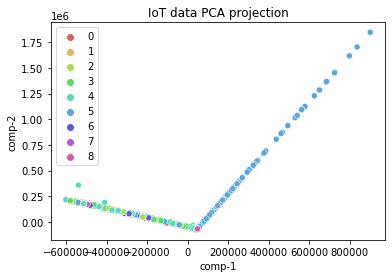

In [21]:
pc = PCA(n_components = 2)
pca = pc.fit_transform(x_train)

#print("components:", pc.components_)
#print("mean:      ", pc.mean_)
#print("covariance:", pc.get_covariance())

pdf = pd.DataFrame()
pdf["y"] = y_train
pdf["comp-1"] = pca[:,0]
pdf["comp-2"] = pca[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=pdf.y.tolist(),
                palette=sns.color_palette("hls", 9),
                data=pdf).set(title="IoT data PCA projection")



In [23]:
y_train.shape

(3000,)

In [23]:
x_train.shape

(3000, 74)

In [24]:
#decision tree classifier for comparison
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(x_train,y_train)
y_pred_tree = tree.predict(x_test)


In [25]:
%conda install -c conda-forge imbalanced-learn

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - conda-forge/noarch::aiobotocore==1.2.1=pyhd8ed1ab_0
  -

In [26]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import classification_report_imbalanced

print("Decision tree classifier performance:")
print(
    
    f"Geometric mean {geometric_mean_score(y_test, y_pred_tree):.2f}"
)

print(classification_report_imbalanced(y_test, y_pred_tree))
print("balanced accuracy score:",balanced_accuracy_score(y_test,y_pred_tree))

Decision tree classifier performance:
Geometric mean 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      1.00      0.99      1.00      0.99     15107
          1       0.40      0.42      0.96      0.41      0.64      0.39      8707
          2       0.30      0.41      0.91      0.35      0.61      0.35     13656
          3       0.31      0.27      0.94      0.29      0.51      0.24     13994
          4       0.56      0.60      0.89      0.58      0.73      0.51     30268
          5       0.82      0.77      0.93      0.79      0.85      0.70     45766
          6       0.82      0.83      0.99      0.83      0.91      0.81      9937
          7       0.17      0.18      0.97      0.17      0.42      0.16      5615
          8       0.38      0.29      0.96      0.33      0.53      0.26     13396

avg / total       0.61      0.60      0.94      0.61      0.74      0.55    156446

balanced accuracy score: 0

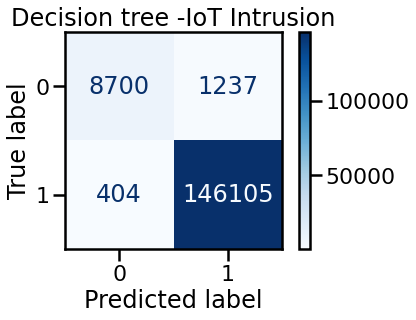

In [18]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

sns.set_context("poster")

disp = plot_confusion_matrix(tree, x_test, y_test, colorbar=True,cmap=plt.cm.Blues)
_ = disp.ax_.set_title("Decision tree -IoT Intrusion")

In [12]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bagging = BaggingClassifier(n_estimators=50, random_state=0)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

bagging.fit(x_train, y_train)
balanced_bagging.fit(x_train, y_train)

y_pred_bc = bagging.predict(x_test)
y_pred_bbc = balanced_bagging.predict(x_test)

In [13]:
print("Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_bc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_bc):.2f}"
)
print("Balanced Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_bbc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_bbc):.2f}"
)

Bagging classifier performance:
Balanced accuracy: 0.93 - Geometric mean 0.93
Balanced Bagging classifier performance:
Balanced accuracy: 0.97 - Geometric mean 0.97


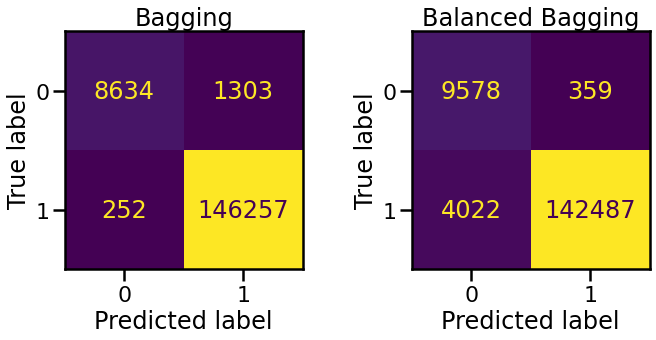

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_confusion_matrix(bagging, x_test, y_test, ax=axs[0], colorbar=False)
axs[0].set_title("Bagging")

plot_confusion_matrix(balanced_bagging, x_test, y_test, ax=axs[1], colorbar=False)
axs[1].set_title("Balanced Bagging")

fig.tight_layout()